# 17 Flowers Classification

In this notebook, we classify the 17 flowers dataset. We'll use both the original dataset, and a color-constancy (CC) version that's been processed by CC methods.

First, we'll work with the original dataset.

## Imports

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import shutil
import pathlib
import re  # Regex
import time

## Preprocessing

Based on https://www.tensorflow.org/tutorials/load_data/images

### Organizing the dataset

To load the dataset using `tf.keras.utils.image_dataset_from_directory()`, the dataset must be divided into subfolders for each label. In the case of 17 flowers, we'll have 17 folders.

The 17 labels are:

In [2]:
# list of class labels
with open("17flowers_labels.txt", "r") as f:
    flower_labels = [line.strip() for line in f]

print(flower_labels)

['Daffodil', 'Snowdrop', 'LilyValley', 'Bluebell', 'Crocus', 'Iris', 'Tigerlily', 'Tulip', 'Fritillary', 'Sunflower', 'Daisy', 'ColtsFoot', 'Dandelion', 'Cowslip', 'Buttercup', 'Windflower', 'Pansy']


We'll use the train/val/test splits provided in the dataset. As such, we'll load the `datasplits.mat` file and gets the splits (i.e., the image ids for each split) from its contents.

In [3]:
import scipy.io
mat = scipy.io.loadmat('./data/17flowers/datasplits.mat')

# The image ids for each split
train_ids = mat["trn1"][0]
val_ids = mat["val1"][0]
test_ids = mat["tst1"][0]

# The amount of images in each split
train_size = len(train_ids)
val_size = len(val_ids)
test_size = len(test_ids)

print(f"Training  : {train_size} images.")
print(f"Validation: {val_size} images.")
print(f"Testing   : {test_size} images.")

Training  : 680 images.
Validation: 340 images.
Testing   : 340 images.


Create the 17 subfolders for each split:

In [4]:
# set the path to the folder containing the images
path_to_data = "data/17flowers/"

def create_subfolders(path):
    """
    Create train/val/test subfolders with 17 subfolders each (1 for each label).
    """
    for split_name in ["train/", "val/", "test/"]:
        for label in flower_labels:
            os.makedirs(path + split_name + label, exist_ok=True)
    print(f"All subfolders created at {path}.")

create_subfolders(path_to_data)

All subfolders created at data/17flowers/.


Copy images to their subfolders:

In [5]:
# move the images into the subfolders
def move_images_to_subfolders(path):
    """
    Copy images from `path/jpg` to `path` subfolders train/val/test and their labels.
    """
    src_path = path + "jpg/"
    for filename in os.listdir(src_path):
        if filename.endswith(".jpg"):
            # Get the id of the image from its filename
            
            file_id = int(re.findall(r'\d+', filename)[0])
            # file_id = int(filename[6:-4])

            # Check which split the file belongs to
            if file_id in train_ids:
                split = "train/"
            elif file_id in val_ids:
                split = "val/"
            elif file_id in test_ids:
                split = "test/"
            else:
                print(f"{filename} isn't associated with any splits.")

            # calculate the subfolder to move the image into
            subfolder_id = (file_id-1) // 80  # File ids start from 1, so subtract one. 80 images per label
            subfolder_name = path + split + flower_labels[subfolder_id]

            # move the image into the subfolder
            shutil.copy(os.path.join(src_path, filename), os.path.join(subfolder_name, filename))
    print(f"Images copied successfully to {path} test/train/val subfolders.")


move_images_to_subfolders(path_to_data)

Images copied successfully to data/17flowers/ test/train/val subfolders.


In [6]:
# Split directories
train_dir = pathlib.Path(path_to_data + "train")
val_dir = pathlib.Path(path_to_data + "val")
test_dir = pathlib.Path(path_to_data + "test")

# Image counts
train_count = len(list(train_dir.glob('*/*.jpg')))
val_count = len(list(val_dir.glob('*/*.jpg')))
test_count = len(list(test_dir.glob('*/*.jpg')))

print(f"Number of images at {path_to_data}: {train_count}/{train_size} (train), {val_count}/{val_size} (val), {test_count}/{test_size} (test)")

# The number of images in each folder should be the same as the amount of ids provided by the datasplits.mat file
assert train_count == train_size, f"Expected {train_size} images, but {train_dir} only has {train_count}"
assert val_count == val_size, f"Expected {train_size} images, but {val_dir} only has {val_count}"
assert test_count == test_size, f"Expected {train_size} images, but {test_dir} only has {test_count}"

Number of images at data/17flowers/: 680/680 (train), 340/340 (val), 340/340 (test)


### Create the training and validation datasets

Parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Create the train, val, and test datasets:

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 680 files belonging to 17 classes.
Found 340 files belonging to 17 classes.
Found 340 files belonging to 17 classes.


Verify class names are correct:

In [9]:
class_names = train_ds.class_names

assert sorted(class_names) == sorted(flower_labels)

### Visualize the data

Here are the first 9 images from the training dataset.

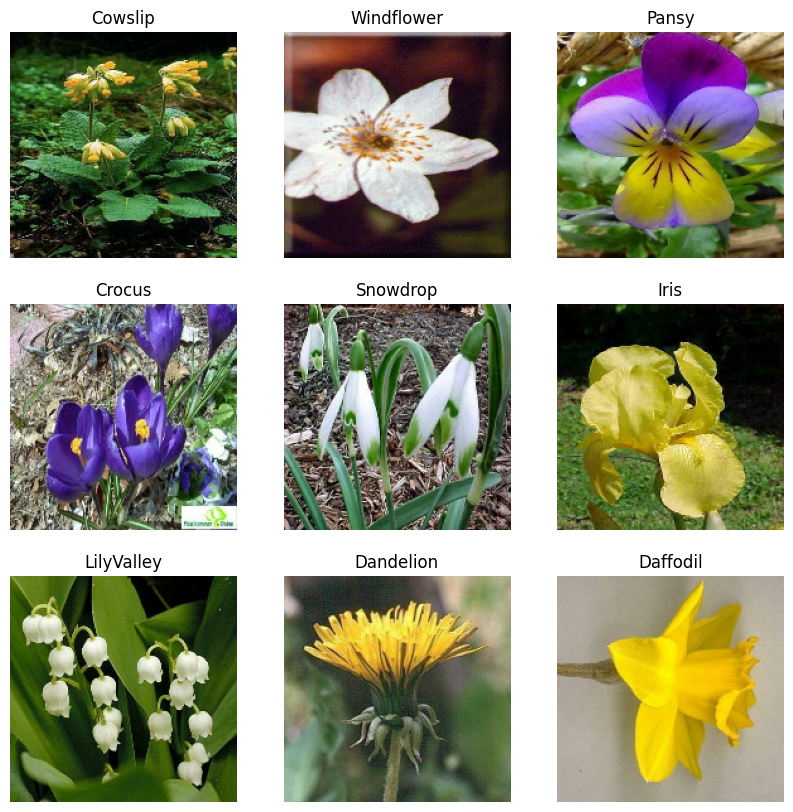

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Retrieve batches of images:

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

### Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, we will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:



In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

We can either apply this layer to the dataset, or include it as part of the model definition. We'll go with the latter.

### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Training and evaluation

We'll create a simple CNN to classify the flowers. Before setting up the architecture, let's define some useful utilities.

### Callbacks

Reduce learning rate on plateau:

In [14]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

Early stopping when loss stops decreasing:

In [15]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

### Data augmentation

Since the dataset is small, we'll use data augmentation to improve training: flip, translation, rotation, and zoom.

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
  tf.keras.layers.RandomTranslation(0.2, 0.2),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

Let's check some of the augmented images:

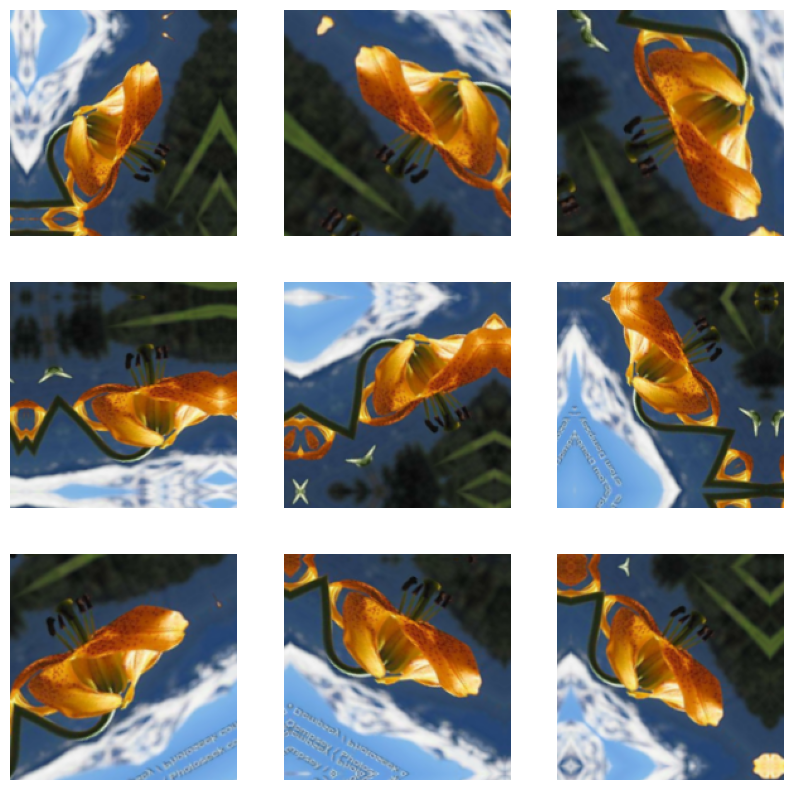

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Creating the model

Here we create the base model for classifying the flowers and to be used as reference in our experiments.

In [18]:
num_classes = 17
n_epochs = 300

def get_model():
  model = tf.keras.Sequential([
    normalization_layer,
    data_augmentation,
    tf.keras.layers.Conv2D(32, 5, activation='relu', padding="same", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
  ])
  return model

model = get_model()

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

Now we fit the model:

In [19]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop],
  verbose=0
)

And evaluate the model:

In [ ]:
score = model.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {score[1]:.3f}')

11/11 [==============================] - 0s 8ms/step - loss: 0.8825 - accuracy: 0.7235
Test accuracy: 0.724


### Batch normalization

We'll also experiment on the use of batch normalization in comparison to applying color constancy. Let's define a model that includes the batch normalization layer.

In [22]:
def get_model_batchnorm():
  model = tf.keras.Sequential([
    normalization_layer,
    data_augmentation,
    tf.keras.layers.Conv2D(32, 5, padding="same", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
  ])
  return model

model_batchnorm = get_model_batchnorm()

model_batchnorm.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

Fit the model:

In [264]:
model_batchnorm.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop],
  verbose=0
)

And evaluate the model:

In [265]:
score = model_batchnorm.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {score[1]:.3f}')

11/11 [==============================] - 0s 9ms/step - loss: 0.8066 - accuracy: 0.7412
Test accuracy: 0.741


# 17 Flowers with Color Constancy (CC)

Now, we'll apply the same pipeline to the dataset after its been processed by color constancy models. There are two methods for this:
- use implemented CC models as Keras layers;
- use the CC'ed dataset, i.e. the 17 flowers dataset preprocessed by a CC model.

In the first case, we just add the layer to our model and fit it to the original dataset. In the second, we need to create new dataset variables using the new image files from the CC'ed dataset.

## CC as Keras layers - Grey World, White Patch, and Grey Edge

Let's start with the Keras layers.

In [21]:
from processing.grey_world.cc_layers import GreyWorld, WhitePatch, GreyEdge

grey_world_layer = GreyWorld()
white_patch_layer = WhitePatch()
grey_edge_layer = GreyEdge()

def get_cc_model(cc_layer):
  model = tf.keras.Sequential([
    normalization_layer,
    cc_layer,
    data_augmentation,
    tf.keras.layers.Conv2D(32, 5, activation='relu', padding="same", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(512, 3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
  ])
  return model

d:\Projects\UJM\DL_CC_Classification\.venv\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Grey World:

In [49]:
cc_model_gw = get_cc_model(grey_world_layer)

cc_model_gw.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

cc_model_gw.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop], 
  verbose=0)

score_cc_gw = cc_model_gw.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {score_cc_gw[1]:.3f}')

Epoch 1/300
22/22 [==============================] - 4s 37ms/step - loss: 2.7913 - accuracy: 0.0618 - val_loss: 2.6043 - val_accuracy: 0.1088 - lr: 0.0010
Epoch 2/300
22/22 [==============================] - 1s 25ms/step - loss: 2.6217 - accuracy: 0.1191 - val_loss: 2.4079 - val_accuracy: 0.1147 - lr: 0.0010
Epoch 3/300
22/22 [==============================] - 1s 23ms/step - loss: 2.4476 - accuracy: 0.1324 - val_loss: 2.3336 - val_accuracy: 0.1735 - lr: 0.0010
Epoch 4/300
22/22 [==============================] - 1s 25ms/step - loss: 2.4028 - accuracy: 0.1456 - val_loss: 2.2008 - val_accuracy: 0.2471 - lr: 0.0010
Epoch 5/300
22/22 [==============================] - 1s 24ms/step - loss: 2.3613 - accuracy: 0.1691 - val_loss: 2.1472 - val_accuracy: 0.2206 - lr: 0.0010
Epoch 6/300
22/22 [==============================] - 1s 24ms/step - loss: 2.2569 - accuracy: 0.2015 - val_loss: 2.0461 - val_accuracy: 0.2853 - lr: 0.0010
Epoch 7/300
22/22 [==============================] - 1s 24ms/step - lo

White Patch:

In [50]:
cc_model_wp = get_cc_model(white_patch_layer)

cc_model_wp.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

cc_model_wp.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop],
  verbose=0)

score_cc_wp = cc_model_wp.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {score_cc_wp[1]:.3f}')

Epoch 1/300
22/22 [==============================] - 4s 37ms/step - loss: 2.8403 - accuracy: 0.0588 - val_loss: 2.8265 - val_accuracy: 0.0471 - lr: 0.0010
Epoch 2/300
22/22 [==============================] - 1s 27ms/step - loss: 2.8056 - accuracy: 0.0544 - val_loss: 2.7512 - val_accuracy: 0.1176 - lr: 0.0010
Epoch 3/300
22/22 [==============================] - 1s 27ms/step - loss: 2.6163 - accuracy: 0.0956 - val_loss: 2.3968 - val_accuracy: 0.1588 - lr: 0.0010
Epoch 4/300
22/22 [==============================] - 1s 26ms/step - loss: 2.4646 - accuracy: 0.1015 - val_loss: 2.3440 - val_accuracy: 0.1765 - lr: 0.0010
Epoch 5/300
22/22 [==============================] - 1s 26ms/step - loss: 2.4155 - accuracy: 0.1294 - val_loss: 2.2519 - val_accuracy: 0.2265 - lr: 0.0010
Epoch 6/300
22/22 [==============================] - 1s 27ms/step - loss: 2.4007 - accuracy: 0.1500 - val_loss: 2.1296 - val_accuracy: 0.2176 - lr: 0.0010
Epoch 7/300
22/22 [==============================] - 1s 26ms/step - lo

Grey Edge:

In [51]:
cc_model_ge = get_cc_model(grey_edge_layer)

cc_model_ge.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

cc_model_ge.fit(
  train_ds,
  validation_data=val_ds,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop], 
  verbose=0)

score_cc_ge = cc_model_ge.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {score_cc_ge[1]:.3f}')

Epoch 1/300
22/22 [==============================] - 4s 45ms/step - loss: 2.8263 - accuracy: 0.0485 - val_loss: 2.8001 - val_accuracy: 0.0912 - lr: 0.0010
Epoch 2/300
22/22 [==============================] - 1s 30ms/step - loss: 2.7602 - accuracy: 0.0765 - val_loss: 2.6272 - val_accuracy: 0.1265 - lr: 0.0010
Epoch 3/300
22/22 [==============================] - 1s 31ms/step - loss: 2.6269 - accuracy: 0.1088 - val_loss: 2.4690 - val_accuracy: 0.1676 - lr: 0.0010
Epoch 4/300
22/22 [==============================] - 1s 29ms/step - loss: 2.6534 - accuracy: 0.1044 - val_loss: 2.4691 - val_accuracy: 0.1559 - lr: 0.0010
Epoch 5/300
22/22 [==============================] - 1s 30ms/step - loss: 2.4986 - accuracy: 0.1529 - val_loss: 2.3210 - val_accuracy: 0.1912 - lr: 0.0010
Epoch 6/300
22/22 [==============================] - 1s 30ms/step - loss: 2.5331 - accuracy: 0.1353 - val_loss: 2.3163 - val_accuracy: 0.1676 - lr: 0.0010
Epoch 7/300
22/22 [==============================] - 1s 30ms/step - lo

## CC'ed Dataset - FC4

Now we'll use the CC'ed Dataset preprocessed by the FC4 CC model.

In [24]:
path_to_data_cc = "data/17flowers/cc/"
create_subfolders(path_to_data_cc)
move_images_to_subfolders(path_to_data_cc)

train_dir_cc = pathlib.Path(path_to_data_cc + "train")
val_dir_cc = pathlib.Path(path_to_data_cc + "val")
test_dir_cc = pathlib.Path(path_to_data_cc + "test")

train_count_cc = len(list(train_dir_cc.glob('*/*.jpg')))
val_count_cc = len(list(val_dir_cc.glob('*/*.jpg')))
test_count_cc = len(list(test_dir_cc.glob('*/*.jpg')))

print(f"Number of images at {path_to_data_cc}: {train_count_cc}/{train_size} (train), {val_count_cc}/{val_size} (val), {test_count_cc}/{test_size} (test)")

assert train_count_cc == train_size, f"Expected {train_size} images, but {train_dir_cc} only has {train_count_cc}"
assert val_count_cc == val_size, f"Expected {train_size} images, but {val_dir_cc} only has {val_count_cc}"
assert test_count_cc == test_size, f"Expected {train_size} images, but {test_dir_cc} only has {test_count_cc}"


All subfolders created at data/17flowers/cc/.
Images copied successfully to data/17flowers/cc/ test/train/val subfolders.
Number of images at data/17flowers/cc/: 680/680 (train), 340/340 (val), 340/340 (test)


In [25]:
train_ds_cc = tf.keras.utils.image_dataset_from_directory(
  train_dir_cc,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds_cc = tf.keras.utils.image_dataset_from_directory(
  val_dir_cc,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

test_ds_cc = tf.keras.utils.image_dataset_from_directory(
  test_dir_cc,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 680 files belonging to 17 classes.
Found 340 files belonging to 17 classes.
Found 340 files belonging to 17 classes.


This is how the dataset looks like:

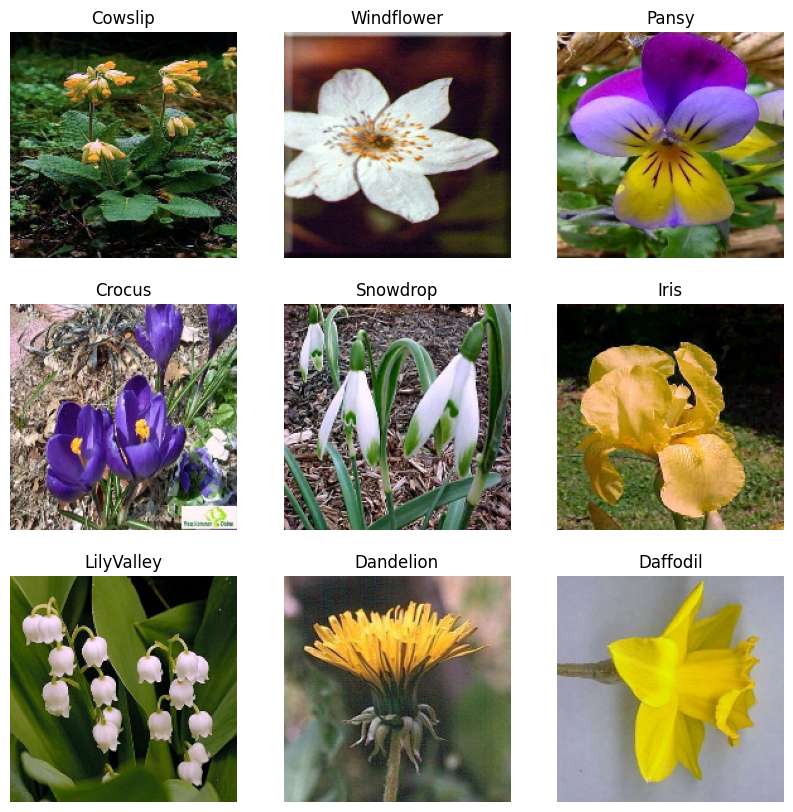

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds_cc.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Finally, optimize the dataset for performance:

In [27]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_cc = train_ds_cc.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_cc = val_ds_cc.cache().prefetch(buffer_size=AUTOTUNE)
test_ds_cc = test_ds_cc.cache().prefetch(buffer_size=AUTOTUNE)

Now we fit the model to the CC'ed dataset:

In [56]:
model_cc_fc4 = get_model()

model_cc_fc4.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

model_cc_fc4.fit(
  train_ds_cc,
  validation_data=val_ds_cc,
  epochs=n_epochs,
  callbacks=[reduce_lr, early_stop], 
  verbose=0)

score_cc_fc4 = model_cc_fc4.evaluate(test_ds_cc, verbose=0)
print(f'Test accuracy: {score_cc_fc4[1]:.3f}')

Epoch 1/300


2023-05-07 18:12:42.424616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [680]
	 [[{{node Placeholder/_4}}]]
2023-05-07 18:12:42.424917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [680]
	 [[{{node Placeholder/_0}}]]


19/22 [========================>.....] - ETA: 0s - loss: 2.8094 - accuracy: 0.0559

2023-05-07 18:12:45.511817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [340]
	 [[{{node Placeholder/_0}}]]
2023-05-07 18:12:45.512133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [340]
	 [[{{node Placeholder/_0}}]]


22/22 [==============================] - 3s 36ms/step - loss: 2.7908 - accuracy: 0.0529 - val_loss: 2.7253 - val_accuracy: 0.0882 - lr: 0.0010
Epoch 2/300
22/22 [==============================] - 0s 23ms/step - loss: 2.5860 - accuracy: 0.1279 - val_loss: 2.4126 - val_accuracy: 0.1206 - lr: 0.0010
Epoch 3/300
22/22 [==============================] - 0s 23ms/step - loss: 2.4284 - accuracy: 0.1353 - val_loss: 2.2942 - val_accuracy: 0.1647 - lr: 0.0010
Epoch 4/300
22/22 [==============================] - 0s 23ms/step - loss: 2.4004 - accuracy: 0.1397 - val_loss: 2.2191 - val_accuracy: 0.2206 - lr: 0.0010
Epoch 5/300
22/22 [==============================] - 0s 22ms/step - loss: 2.2856 - accuracy: 0.1662 - val_loss: 2.0696 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 6/300
22/22 [==============================] - 0s 22ms/step - loss: 2.2699 - accuracy: 0.1809 - val_loss: 2.0787 - val_accuracy: 0.2588 - lr: 0.0010
Epoch 7/300
22/22 [==============================] - 1s 23ms/step - loss: 2.1367 -

2023-05-07 18:13:58.773815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [340]
	 [[{{node Placeholder/_0}}]]
2023-05-07 18:13:58.774195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [340]
	 [[{{node Placeholder/_0}}]]


11/11 [==============================] - 0s 9ms/step - loss: 0.9501 - accuracy: 0.7529
Test accuracy: 0.753


# Experiment

For the evaluation experiment, we'll run 10 trials of training/evaluation for each model. The collected data will be:
- time, accuracy, and loss for train, validation, and test;
- number of epochs

We'll compare all results with the base model.

In [28]:
import time

def experiment(model, train_ds, val_ds, test_ds, n_trials=10):
    metrics = {
        "train_time": [],
        "test_time": [],
        "train_acc": [],
        "train_loss": [],
        "val_acc": [],
        "val_loss": [],
        "test_acc": [],
        "test_loss": [],
        "history": []
    }

    for i in range(n_trials):        
        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

        start_time = time.perf_counter()
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=n_epochs,
            callbacks=[reduce_lr, early_stop],
            verbose=0)
        end_time = time.perf_counter()
        training_time = end_time - start_time

        start_time = time.perf_counter()
        test_loss, test_acc = model.evaluate(test_ds, verbose=0)
        end_time = time.perf_counter()
        test_time = end_time - start_time

        metrics["train_time"].append(training_time)
        metrics["test_time"].append(test_time)
        metrics["train_acc"].append(history.history["accuracy"][-1])
        metrics["train_loss"].append(history.history["loss"][-1])
        metrics["val_acc"].append(history.history["val_accuracy"][-1])
        metrics["val_loss"].append(history.history["val_loss"][-1])
        metrics["test_acc"].append(test_acc)
        metrics["test_loss"].append(test_loss)
        metrics["history"].append(history)
    return metrics

In [31]:
# Create new models
model_base = get_model()
model_batch = get_model_batchnorm()
model_gw = get_cc_model(grey_world_layer)
model_ge = get_cc_model(grey_edge_layer)
model_wp = get_cc_model(white_patch_layer)
model_fc4 = get_model()

# Run experiments
n_trials = 1
metrics = {}
metrics["Base"] = experiment(model_base, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics["BatchNorm"] = experiment(model_batch, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics["GreyWorld"] = experiment(model_gw, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics["GreyEdge"] = experiment(model_ge, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics["WhitePatch"] = experiment(model_wp, train_ds, val_ds, test_ds, n_trials=n_trials)
metrics["FC4"] = experiment(model_fc4, train_ds_cc, val_ds_cc, test_ds_cc, n_trials=n_trials)

KeyboardInterrupt: 

In [ ]:
import pandas as pd

with pd.ExcelWriter("./out/experiments_17flowers.xlsx", engine='xlsxwriter',) as writer:    
    end_data = pd.concat({k: pd.DataFrame(v) for k, v in metrics.items()}, axis=0, names=["Algorithm", "Trial"])
    end_data.drop("history", axis=1, inplace=True)
    print(end_data)

    end_data.to_excel(writer, "Final Data")

    for k, metric in metrics.items():
        histories = metric["history"]
        algo_data = pd.concat({f"{i}": pd.DataFrame(history.history) for i, history in enumerate(histories)}, axis=1)
        print(algo_data)
        algo_data.to_excel(writer, f"{k} History")

Now let's visualize the results.

In [318]:
def calc_y_limits(y, margin=0.15):
    """
        Return min and max values for the provided y values according to given margin.
        To be used with matplotlib `set_ylim()`.
    """
    y_min = np.min(y)
    y_max = np.max(y)
    y_range = y_max - y_min
    y_margin = margin * y_range
    y_min_limit = y_min - y_margin
    y_max_limit = y_max + y_margin
    return y_min_limit, y_max_limit


def add_history_avg(all_metrics, n_trials):
    """
        Add "history_avg" key to all provided metrics, which contains the average values
        for all the `history` objects inside the metric.

        Basically calculates averages of the training history so that they can be plotted.
    """
    for m in all_metrics:
        m["history_avg"] = {
        "accuracy": [],
        "loss": [],
        "val_accuracy": [],
        "val_loss": []
        }
        for kpi in m["history_avg"].keys():
            n_epochs = []
            for trial in range(n_trials):
                # Check all trials to find the one with most epochs. We'll calculate averages until the last epoch.
                n_epochs.append(len(m["history"][trial].history[kpi]))
            for epoch in range(max(n_epochs)):
                epoch_values = []
                epoch_count = 0
                for trial in range(n_trials):
                    try:
                        epoch_values.append(m["history"][trial].history[kpi][epoch])
                        epoch_count += 1
                    except IndexError:
                        # We skip counting when a trial has less epochs than the current epoch.
                        # Doing this causes abrupt changes to show up along the plot.
                        pass
                epoch_avg = sum(epoch_values)/epoch_count
                m["history_avg"][kpi].append(epoch_avg)

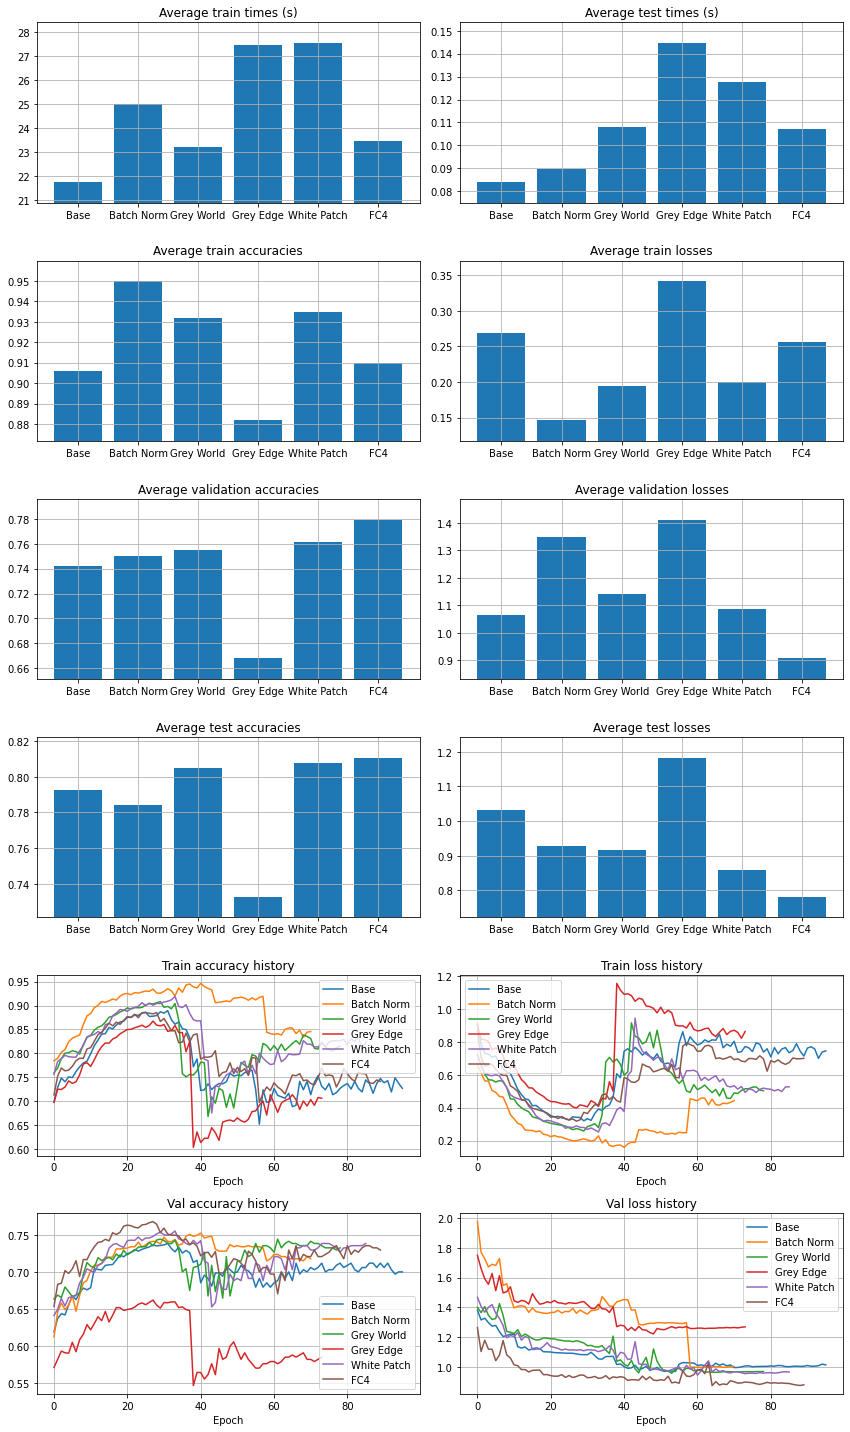

In [328]:
all_metrics = [metrics_base, metrics_batch, metrics_gw, metrics_ge, metrics_wp, metrics_fc4]

train_time_avg = [sum(m["train_time"])/n_trials for m in all_metrics]
test_time_avg = [sum(m["test_time"])/n_trials for m in all_metrics]
train_acc_avg = [sum(m["train_acc"])/n_trials for m in all_metrics]
train_loss_avg = [sum(m["train_loss"])/n_trials for m in all_metrics]
val_acc_avg = [sum(m["val_acc"])/n_trials for m in all_metrics]
val_loss_avg = [sum(m["val_loss"])/n_trials for m in all_metrics]
test_acc_avg = [sum(m["test_acc"])/n_trials for m in all_metrics]
test_loss_avg = [sum(m["test_loss"])/n_trials for m in all_metrics] 

add_history_avg(all_metrics, n_trials)

# Create a 4x2 grid of plots
nrows = 6
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 20))

# --- Plots
x_axis = ["Base", "Batch Norm", "Grey World", "Grey Edge", "White Patch", "FC4"]

# Time
axs[0, 0].bar(x_axis, train_time_avg)
axs[0, 0].set_title('Average train times (s)')
y_limit = calc_y_limits(train_time_avg)
axs[0, 0].set_ylim(y_limit[0], y_limit[1])

axs[0, 1].bar(x_axis, test_time_avg)
axs[0, 1].set_title('Average test times (s)')
y_limit = calc_y_limits(test_time_avg)
axs[0, 1].set_ylim(y_limit[0], y_limit[1])

# Train acc and loss
axs[1, 0].bar(x_axis, train_acc_avg)
axs[1, 0].set_title('Average train accuracies')
y_limit = calc_y_limits(train_acc_avg)
axs[1, 0].set_ylim(y_limit[0], y_limit[1])

axs[1, 1].bar(x_axis, train_loss_avg)
axs[1, 1].set_title('Average train losses')
y_limit = calc_y_limits(train_loss_avg)
axs[1, 1].set_ylim(y_limit[0], y_limit[1])

# Validation acc and loss
axs[2, 0].bar(x_axis, val_acc_avg)
axs[2, 0].set_title('Average validation accuracies')
y_limit = calc_y_limits(val_acc_avg)
axs[2, 0].set_ylim(y_limit[0], y_limit[1])

axs[2, 1].bar(x_axis, val_loss_avg)
axs[2, 1].set_title('Average validation losses')
y_limit = calc_y_limits(val_loss_avg)
axs[2, 1].set_ylim(y_limit[0], y_limit[1])

# Test acc and loss
axs[3, 0].bar(x_axis, test_acc_avg)
axs[3, 0].set_title('Average test accuracies')
y_limit = calc_y_limits(test_acc_avg)
axs[3, 0].set_ylim(y_limit[0], y_limit[1])

axs[3, 1].bar(x_axis, test_loss_avg)
axs[3, 1].set_title('Average test losses')
y_limit = calc_y_limits(test_loss_avg)
axs[3, 1].set_ylim(y_limit[0], y_limit[1])

# History
for m in all_metrics:
    axs[4, 0].plot(m["history_avg"]["accuracy"], label=x_axis[all_metrics.index(m)])
    axs[4, 1].plot(m["history_avg"]["loss"], label=x_axis[all_metrics.index(m)])
    axs[5, 0].plot(m["history_avg"]["val_accuracy"], label=x_axis[all_metrics.index(m)])
    axs[5, 1].plot(m["history_avg"]["val_loss"], label=x_axis[all_metrics.index(m)])
axs[4, 0].set_title('Train accuracy history')
axs[4, 0].legend()
axs[4, 1].set_title('Train loss history')
axs[4, 1].legend()
axs[5, 0].set_title('Val accuracy history')
axs[5, 0].legend()
axs[5, 1].set_title('Val loss history')
axs[5, 1].legend()

for i in range(4, nrows):
    for j in range(ncols):
        axs[i, j].set_xlabel("Epoch")

# Enable grid
for i in range(nrows):
    for j in range(ncols):
        axs[i, j].grid()

# Add some spacing between the plots
fig.tight_layout()

# Save plot to PNG file
os.makedirs("./out/", exist_ok=True)
plt.savefig('./out/experiment_plots.png')

# Display the plot
plt.show()


Now let's prepare a pandas dataframe and save the data to an excel sheet.

In [336]:
import pandas as pd

df = pd.DataFrame({
    "model": x_axis,
    "train_time_avg": train_time_avg,
    "test_time_avg": test_time_avg,
    "train_acc_avg": train_acc_avg,
    "train_loss_avg": train_loss_avg,
    "val_acc_avg": val_acc_avg,
    "val_loss_avg": val_loss_avg,
    "test_acc_avg": test_acc_avg,
    "test_loss_avg": test_loss_avg,
})

for kpi in metrics_base.keys():
    if kpi == "history" or kpi == "history_avg":
        continue
    df[f"{kpi}_min"] = [min(m[kpi]) for m in all_metrics]
    df[f"{kpi}_max"] = [max(m[kpi]) for m in all_metrics]
    df[f"{kpi}_std"] = [np.std(m[kpi]) for m in all_metrics]
    
for key in metrics_base["history_avg"].keys():
    df[f"history_avg_{key}"] = [m["history_avg"][key] for m in all_metrics]

# Sort column names alphabetically except for the model and history_avg columns
cols = list(df.columns)
cols.remove('model') 
cols.remove('history_avg_accuracy')
cols.remove('history_avg_loss')
cols.remove('history_avg_val_accuracy')
cols.remove('history_avg_val_loss')
cols_sorted = sorted(cols)
cols_sorted = ['model'] + cols_sorted + ["history_avg_accuracy", 'history_avg_loss', 'history_avg_val_accuracy', 'history_avg_val_loss']
df = df.reindex(columns=cols_sorted)

df.head()

,model,test_acc_avg,test_acc_max,test_acc_min,test_acc_std,test_loss_avg,test_loss_max,test_loss_min,test_loss_std,test_time_avg,...,val_acc_min,val_acc_std,val_loss_avg,val_loss_max,val_loss_min,val_loss_std,history_avg_accuracy,history_avg_loss,history_avg_val_accuracy,history_avg_val_loss
0,Base,0.792353,0.811765,0.747059,0.019563,1.030901,1.215607,0.887458,0.111921,0.084058,...,0.700000,0.018464,1.066280,1.258316,0.916356,0.112489,"[0.6982352901250124, 0.728529417514801, 0.7482...","[0.9107053965330124, 0.7863991230726242, 0.731...","[0.6194117609411478, 0.6373529352247715, 0.643...","[1.3807985126972198, 1.3149094223976134, 1.326..."
1,Batch Norm,0.784412,0.808824,0.741176,0.021170,0.927448,1.092162,0.767566,0.101600,0.089548,...,0.717647,0.012409,1.349960,1.627375,1.002197,0.215346,"[0.7844117730855942, 0.789558830857277, 0.8020...","[0.6640755504369735, 0.6123338580131531, 0.563...","[0.612647058814764, 0.6458823375403882, 0.6582...","[1.9761396169662475, 1.7703418970108031, 1.726..."
2,Grey World,0.805000,0.826471,0.770588,0.017102,0.916068,1.009045,0.836918,0.048706,0.107975,...,0.732353,0.012603,1.140121,1.342734,0.967899,0.116437,"[0.7594117630273104, 0.7689705930650235, 0.788...","[0.7187593787908554, 0.6671709388494491, 0.604...","[0.6635294087231159, 0.6688235245645047, 0.665...","[1.40054132938385, 1.3637346625328064, 1.40491..."
3,Grey Edge,0.732941,0.776471,0.644118,0.037129,1.182505,1.303380,1.073579,0.074364,0.144545,...,0.585294,0.034412,1.412143,1.605517,1.218798,0.142753,"[0.6972058858722449, 0.7248529378324747, 0.724...","[0.902523535490036, 0.8175677835941315, 0.8144...","[0.5714705921709538, 0.5823529426008462, 0.593...","[1.7489866256713866, 1.660696530342102, 1.5915..."
4,White Patch,0.807647,0.832353,0.782353,0.014951,0.858865,0.990114,0.726705,0.091524,0.127739,...,0.735294,0.015195,1.087499,1.280541,0.940779,0.101524,"[0.7557352986186743, 0.782941173017025, 0.7886...","[0.7286984413862229, 0.6500515013933181, 0.612...","[0.6414705820381641, 0.6497058726847171, 0.664...","[1.4668345212936402, 1.4063955903053285, 1.366..."


Export to Excel:

In [329]:
df.to_excel('./out/experiment_results.xlsx', index=False)

# Tensorboard

We can use Tensorboard to visualize training data for a model.

In [322]:
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

def run_with_tensorboard(model, train_ds, val_ds):
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])

    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=n_epochs,
        callbacks=[reduce_lr, early_stop, tensorboard], 
        verbose=0)

To open Tensorboard, run the following in the terminal:

```sh
tensorboard logsdir=./logs
```

If `tensorboard` is not in `PATH`, you can use the path to the binary instead. VS Code has Tensorboard integration, so it can also be used.

In [323]:
model_tensorboard = get_model()

run_with_tensorboard(model_tensorboard, train_ds, val_ds)